<a href="https://colab.research.google.com/github/Nkashyap-anand/human-posture-estimation/blob/main/keras_resnet_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow import keras
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split

In [3]:
# Create ImageDataGenerator to handle loading and preprocessing images
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load the images from your local storage
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/posture/training',
    target_size=(512, 512),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/posture/validation',
    target_size=(512, 512),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2304 images belonging to 4 classes.
Found 192 images belonging to 4 classes.


In [5]:
# Define the ResNet model
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
      """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
      conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(1e-4))

      x = inputs
      if conv_first:
          x = conv(x)
          if batch_normalization:
              x = BatchNormalization()(x)
          if activation is not None:
              x = Activation(activation)(x)
      else:
          if batch_normalization:
              x = BatchNormalization()(x)
          if activation is not None:
              x = Activation(activation)(x)
          x = conv(x)
      return x



def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
        # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=(8,8))(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the ResNet model
model = resnet_v1(input_shape=(512, 512, 1), depth=20, num_classes=4)


# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit the model using the generator
history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=train_generator.samples // 32,
                              validation_steps=validation_generator.samples // 32,
                              epochs=10)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate_generator(validation_generator, steps=validation_generator.samples // 32)

print('test acc:', test_acc)


<ipython-input-5-90b388deeeb4>:116: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/10
72/72 [==============================] - 674s 9s/step - loss: 2.4013 - accuracy: 0.6198 - val_loss: 16.9971 - val_accuracy: 0.1510
Epoch 2/10
72/72 [==============================] - 124s 2s/step - loss: 0.8122 - accuracy: 0.7622 - val_loss: 5.2208 - val_accuracy: 0.2396
Epoch 3/10
72/72 [==============================] - 124s 2s/step - loss: 0.5948 - accuracy: 0.8429 - val_loss: 1.1598 - val_accuracy: 0.5573
Epoch 4/10
72/72 [==============================] - 124s 2s/step - loss: 0.5065 - accuracy: 0.8806 - val_loss: 1.0036 - val_accuracy: 0.6458
Epoch 5/10
72/72 [==============================] - 124s 2s/step - loss: 0.4251 - accuracy: 0.9076 - val_loss: 1.2028 - val_accuracy: 0.7083
Epoch 6/10
72/72 [==============================] - 124s 2s/step - loss: 0.3885 - accuracy: 0.9214 - val_loss: 0.9540 - val_accuracy: 0.7500
Epoch 7/10
72/72 [==============================] - 124s 2s/step - loss: 0.3601 - accuracy: 0.9227 - val_loss: 1.0434 - val_accuracy: 0.7760
Epoch 8/10
7

<ipython-input-5-90b388deeeb4>:123: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(validation_generator, steps=validation_generator.samples // 32)


test acc: 0.84375


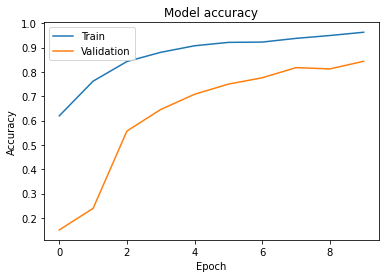

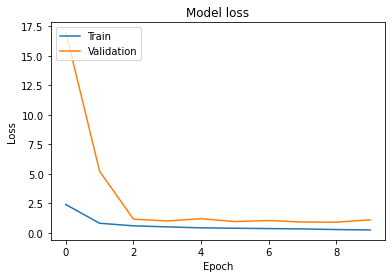

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
